<a href="https://colab.research.google.com/github/juno-yuu/COVID-Vaccine-and-Biotech-industry/blob/Erin/Final_Project_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Github

In [220]:
#!git clone https://github.com/juno-yuu/COVID-Vaccine-and-Biotech-industry.git

### Imports

In [221]:
import warnings
warnings.filterwarnings('ignore')
import requests
import io
import pandas.util.testing as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

### Read Datasets

In [222]:
# vaccination dataset
# vacci = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/us_state_vaccinations.csv", index_col = 0)
vacci = pd.read_csv('https://raw.githubusercontent.com/juno-yuu/COVID-Vaccine-and-Biotech-industry/main/us_state_vaccinations.csv', index_col = 0)

# comfirmed
case_confirmed = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/time_series_covid19_confirmed_US.csv")

# death
case_death = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/time_series_covid19_deaths_US.csv")

# latest data
update = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/05-26-2021_us.csv")

# manufacture daily
# download = requests.get('https://raw.githubusercontent.com/xinyanz-erin/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv').content
# manu = pd.read_csv(io.StringIO(download.decode('utf-8')))
manu = pd.read_csv("https://raw.githubusercontent.com/xinyanz-erin/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv", index_col = 1)

mrna = pd.read_csv('https://raw.githubusercontent.com/juno-yuu/COVID-Vaccine-and-Biotech-industry/main/MRNA.csv', index_col = 0).rename(str.lower, axis='columns')
pfe = pd.read_csv('https://raw.githubusercontent.com/juno-yuu/COVID-Vaccine-and-Biotech-industry/main/PFE.csv', index_col = 0).rename(str.lower, axis='columns')
jnj = pd.read_csv('https://raw.githubusercontent.com/juno-yuu/COVID-Vaccine-and-Biotech-industry/main/JNJ.csv', index_col = 0).rename(str.lower, axis='columns')

### Check datasets

In [223]:
vacci.head()

,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,
2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222
2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212
2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226
2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN


In [247]:
case_confirmed.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6760,6763,6763,6773,6793,6819,6835,6876,6879,6882,6889,6890,6897,6904,6907,6909,6910,6910,6914,6914,6918,6918,6920,6920,6926,6928,6938,6971,7001,7005,7010,7015,7017,7049,7106,7113,7118,7118,7126,7135
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20714,20723,20730,20764,20787,20815,20833,20838,20847,20863,20875,20897,20921,20941,20966,20983,20993,20993,21035,21093,21107,21123,21131,21135,21154,21170,21191,21290,21392,21411,21422,21444,21467,21489,21511,21535,21546,21554,21578,21593
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2271,2271,2271,2275,2284,2289,2292,2296,2296,2296,2297,2298,2299,2300,2302,2302,2302,2302,2307,2307,2307,2307,2308,2308,2310,2314,2317,2319,2320,2320,2320,2322,2324,2326,2327,2328,2328,2328,2331,2331
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2563,2563,2567,2569,2569,2573,2578,2582,2584,2584,2588,2591,2593,2594,2596,2596,2597,2597,2604,2604,2604,2605,2607,2607,2609,2612,2615,2630,2645,2647,2648,2651,2652,2656,2657,2656,2658,2659,2660,2662
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6529,6532,6532,6548,6556,6563,6570,6570,6571,6574,6581,6595,6607,6613,6616,6619,6621,6621,6635,6645,6651,6656,6660,6661,6678,6680,6694,6750,6771,6773,6776,6794,6808,6816,6826,6829,6832,6832,6847,6856


In [248]:
case_death.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,106,106,106,106,107,107,107,107,107,107,107,107,107,107,107,107,107,107,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,109,109,110,110,110,110,110
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,302,302,302,302,302,303,303,305,305,305,305,305,305,305,306,306,306,306,307,307,307,308,308,308,308,309,309,309,310,310,310,310,310,310,310,310,310,310,310,310
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55,55,55,55,55,56,56,56,56,56,56,56,56,56,56,56,56,56,56,57,57,57,57,57,57,56,56,56,56,56,56,56,56,58,58,58,58,58,58,58
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,61,61,61,61,61,62,62,62,62,62,62,63,63,63,63,63,63,63,63,63,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,133,133,133,133,133,133,134,134,134,134,134,134,135,135,135,135,135,135,136,136,137,137,137,137,137,137,137,139,139,139,139,139,139,139,139,139,139,139,139,139


In [249]:
update.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2021-05-27 04:30:49,32.3182,-86.9023,542831,11138,NaN,NaN,1.0,11070.987532,2600239.0,NaN,2.051836,84000001.0,USA,53031.631480,NaN
1,Alaska,US,2021-05-27 04:30:49,61.3707,-152.4044,70119,369,NaN,NaN,2.0,9585.056285,2243112.0,NaN,0.526248,84000002.0,USA,306626.660014,NaN
2,American Samoa,US,2021-05-27 04:30:49,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,2140.0,NaN,NaN,16.0,ASM,3846.084722,NaN
3,Arizona,US,2021-05-27 04:30:49,33.7298,-111.4312,878338,17576,NaN,NaN,4.0,12067.209097,9614180.0,NaN,2.001052,84000004.0,USA,132086.190465,NaN
4,Arkansas,US,2021-05-27 04:30:49,34.9697,-92.3731,340698,5827,NaN,NaN,5.0,11289.599987,3041698.0,NaN,1.710312,84000005.0,USA,100791.767789,NaN


In [250]:
manu.head()

,location,vaccine,total_vaccinations
date,,,
2020-12-24,Chile,Pfizer/BioNTech,420
2020-12-25,Chile,Pfizer/BioNTech,5198
2020-12-26,Chile,Pfizer/BioNTech,8338
2020-12-27,Chile,Pfizer/BioNTech,8649
2020-12-28,Chile,Pfizer/BioNTech,8649


### Data Cleaning and Combining

In [228]:
manu.location.unique()
manu.vaccine.unique()

array(['Pfizer/BioNTech', 'Sinovac', 'Oxford/AstraZeneca', 'Moderna',
       'Johnson&Johnson'], dtype=object)

In [229]:
Pf_manu = manu.loc[manu.vaccine == 'Pfizer/BioNTech']
Pf_manu = Pf_manu.loc[Pf_manu.location == 'United States', ['vaccine', 'total_vaccinations']]
print(Pf_manu.head())

Mod_manu = manu.loc[manu.vaccine == 'Moderna']
Mod_manu = Mod_manu.loc[Mod_manu.location == 'United States', ['vaccine', 'total_vaccinations']]
print(Pf_manu.head())

JJ_manu = manu.loc[manu.vaccine == 'Johnson&Johnson']
JJ_manu = JJ_manu.loc[JJ_manu.location == 'United States', ['vaccine', 'total_vaccinations']]
print(Pf_manu.head())

                    vaccine  total_vaccinations
date                                           
2021-01-12  Pfizer/BioNTech             5488697
2021-01-13  Pfizer/BioNTech             6025872
2021-01-15  Pfizer/BioNTech             7153268
2021-01-19  Pfizer/BioNTech             8874811
2021-01-20  Pfizer/BioNTech             9281063
                    vaccine  total_vaccinations
date                                           
2021-01-12  Pfizer/BioNTech             5488697
2021-01-13  Pfizer/BioNTech             6025872
2021-01-15  Pfizer/BioNTech             7153268
2021-01-19  Pfizer/BioNTech             8874811
2021-01-20  Pfizer/BioNTech             9281063
                    vaccine  total_vaccinations
date                                           
2021-01-12  Pfizer/BioNTech             5488697
2021-01-13  Pfizer/BioNTech             6025872
2021-01-15  Pfizer/BioNTech             7153268
2021-01-19  Pfizer/BioNTech             8874811
2021-01-20  Pfizer/BioNTech             

In [230]:
# keep stats level data
vacci = vacci[vacci.location != 'United States']
vacci_us = vacci.groupby('date').sum()
vacci_us.head()

,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,
2021-01-12,10278912.0,32081325.0,8347766.0,14.16,174.26,784657.0,114.74,573.67,0.0,0.0,0.0,22.063
2021-01-13,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508
2021-01-14,12374484.0,35343775.0,10886077.0,0.00,209.66,0.0,178.06,624.62,1011845.0,1047786.0,176936.0,23.766
2021-01-15,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954
2021-01-16,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,947221.5,1083109.0,182231.0,0.000


In [231]:
Pf_manu_vacci = Pf_manu.join(vacci_us, how = 'left', lsuffix = '_manu', rsuffix = '_vacci')
Pf_manu_vacci.head(10)

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,,
2021-01-12,Pfizer/BioNTech,5488697,10278912.0,32081325.0,8347766.0,14.16,174.26,784657.0,114.74,573.67,0.0,0.0,0.0,22.063
2021-01-13,Pfizer/BioNTech,6025872,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508
2021-01-15,Pfizer/BioNTech,7153268,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954
2021-01-19,Pfizer/BioNTech,8874811,17453029.0,31161075.0,13595803.0,39.95,294.24,2023124.0,252.75,650.16,947221.5,1024875.0,171345.0,31.303
2021-01-20,Pfizer/BioNTech,9281063,18433513.0,35990150.0,14270417.0,43.04,309.90,2161419.0,265.22,716.83,980484.0,1010126.0,166520.0,28.830
2021-01-21,Pfizer/BioNTech,9817027,19635555.0,37960000.0,15053257.0,48.18,330.89,2394961.0,281.05,748.19,1202042.0,1037298.0,173267.0,29.246
2021-01-22,Pfizer/BioNTech,10695066,21397243.0,39892400.0,16243093.0,55.35,359.79,2756953.0,302.55,774.72,1761688.0,1104734.0,183333.0,30.468
2021-01-23,Pfizer/BioNTech,11471457,22975660.0,41411550.0,17390345.0,59.93,384.49,3027865.0,322.48,795.34,1578417.0,1194901.0,196176.0,31.705
2021-01-24,Pfizer/BioNTech,12153536,24415673.0,41411550.0,18502131.0,63.41,410.77,3216836.0,345.12,795.34,1440013.0,1265296.0,211301.0,33.769


In [232]:
Mod_manu_vacci = Mod_manu.join(vacci_us, how = 'left', lsuffix = '_manu', rsuffix = '_vacci')
Mod_manu_vacci.head(10)

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,,
2021-01-12,Moderna,3835859,10278912.0,32081325.0,8347766.0,14.16,174.26,784657.0,114.74,573.67,0.0,0.0,0.0,22.063
2021-01-13,Moderna,4249795,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508
2021-01-15,Moderna,5122662,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954
2021-01-19,Moderna,6828561,17453029.0,31161075.0,13595803.0,39.95,294.24,2023124.0,252.75,650.16,947221.5,1024875.0,171345.0,31.303
2021-01-20,Moderna,7239750,18433513.0,35990150.0,14270417.0,43.04,309.90,2161419.0,265.22,716.83,980484.0,1010126.0,166520.0,28.830
2021-01-21,Moderna,7724683,19635555.0,37960000.0,15053257.0,48.18,330.89,2394961.0,281.05,748.19,1202042.0,1037298.0,173267.0,29.246
2021-01-22,Moderna,8407909,21397243.0,39892400.0,16243093.0,55.35,359.79,2756953.0,302.55,774.72,1761688.0,1104734.0,183333.0,30.468
2021-01-23,Moderna,9061112,22975660.0,41411550.0,17390345.0,59.93,384.49,3027865.0,322.48,795.34,1578417.0,1194901.0,196176.0,31.705
2021-01-24,Moderna,9689497,24415673.0,41411550.0,18502131.0,63.41,410.77,3216836.0,345.12,795.34,1440013.0,1265296.0,211301.0,33.769


In [233]:
JJ_manu_vacci = JJ_manu.join(vacci_us, how = 'left', lsuffix = '_manu', rsuffix = '_vacci')
JJ_manu_vacci.head()

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,,
2021-03-08,Johnson&Johnson,208590,103758241.0,122473710.0,62549309.0,612.21,1767.85,32897443.0,1135.82,2398.49,1824650.0,2287671.0,377665.0,48.104
2021-03-09,Johnson&Johnson,308181,105467512.0,129540430.0,63678459.0,623.33,1794.28,33544611.0,1152.60,2507.32,1709271.0,2277293.0,384672.0,46.492
2021-03-10,Johnson&Johnson,458911,107614717.0,134410410.0,65089854.0,639.85,1836.32,34385505.0,1180.36,2583.54,2147205.0,2294866.0,400701.0,46.015
2021-03-11,Johnson&Johnson,638469,110233615.0,137798185.0,66767597.0,658.40,1881.51,35389429.0,1209.30,2644.55,2618898.0,2359359.0,410068.0,46.039
2021-03-12,Johnson&Johnson,873726,113299843.0,140121405.0,68719280.0,681.17,1937.86,36578051.0,1245.49,2681.15,3066228.0,2428889.0,422884.0,46.740


In [234]:
vacci['daily_vaccinations_lagged'] = vacci['daily_vaccinations'].shift(1) # get the lagged daily vaccinations data
Pf_manu_vacci['daily_vaccinations_lagged'] = Pf_manu_vacci['daily_vaccinations'].shift(1) # get the lagged daily vaccinations data
Mod_manu_vacci['daily_vaccinations_lagged'] = Mod_manu_vacci['daily_vaccinations'].shift(1)
JJ_manu_vacci['daily_vaccinations_lagged'] = JJ_manu_vacci['daily_vaccinations'].shift(1)

### Predictions

#### Panel Regression

In [235]:
# ultimate = (Pf_manu_vacci.append(Mod_manu_vacci)).append(JJ_manu_vacci)
# ultimate = ultimate.dropna()
# ultimate.head(20)
# plt.figure()
# ax = sns.scatterplot(x = 'daily_vaccinations_lagged', y = 'daily_vaccinations', data = ultimate, hue = 'vaccine', legend = 'brief')
# plt.legend()
# plt.show

In [236]:
!pip install linearmodels

In [237]:
from linearmodels.panel import PanelOLS
from patsy import dmatrices

In [238]:
data_panel = vacci.copy().dropna()
data_panel = data_panel.reset_index()
data_panel['loc'] = data_panel['location']
data_panel['time'] = data_panel['date']

In [239]:
data_panel_train = data_panel.loc[data_panel.date < '2021-03-11']
data_panel_train['date'] = pd.to_datetime(data_panel_train['date'], format='%Y-%m-%d', errors='ignore')
data_panel_train = data_panel_train.set_index(['location', 'date'])
data_panel_test = data_panel.loc[data_panel.date >= '2021-03-11']
data_panel_test['date'] = pd.to_datetime(data_panel_test['date'], format='%Y-%m-%d', errors='ignore')
data_panel_test = data_panel_test.set_index(['location', 'date'])

In [240]:
p1 = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged', data = data_panel_train).fit()
p1.summary

Dep. Variable:,daily_vaccinations,R-squared:,0.9881
Estimator:,PanelOLS,R-squared (Between):,0.9999
No. Observations:,3021,R-squared (Within):,0.9079
Date:,"Thu, May 27 2021",R-squared (Overall):,0.9881
Time:,23:08:23,Log-likelihood,-2.907e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2.498e+05
Entities:,60,P-value,0.0000
Avg Obs:,50.350,Distribution:,"F(1,3019)"
Min Obs:,22.000,,
Max Obs:,51.000,F-statistic (robust):,2.498e+05


In [241]:
p2 = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged',\
                                     data = data_panel_train).fit(cov_type = 'clustered', cov_kwds = {'groups': data_panel_train['loc']})
p2.summary

Dep. Variable:,daily_vaccinations,R-squared:,0.9881
Estimator:,PanelOLS,R-squared (Between):,0.9999
No. Observations:,3021,R-squared (Within):,0.9079
Date:,"Thu, May 27 2021",R-squared (Overall):,0.9881
Time:,23:08:23,Log-likelihood,-2.907e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.498e+05
Entities:,60,P-value,0.0000
Avg Obs:,50.350,Distribution:,"F(1,3019)"
Min Obs:,22.000,,
Max Obs:,51.000,F-statistic (robust):,2.452e+04


In [242]:
p3 = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged + EntityEffects + TimeEffects',\
                                     data = data_panel_train).\
                                     fit(cov_type = 'clustered', cov_kwds = {'groups': data_panel_train[['loc','time']]})
p3.summary

Dep. Variable:,daily_vaccinations,R-squared:,0.8912
Estimator:,PanelOLS,R-squared (Between):,0.9944
No. Observations:,3021,R-squared (Within):,0.9109
Date:,"Thu, May 27 2021",R-squared (Overall):,0.9837
Time:,23:08:23,Log-likelihood,-2.875e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.383e+04
Entities:,60,P-value,0.0000
Avg Obs:,50.350,Distribution:,"F(1,2910)"
Min Obs:,22.000,,
Max Obs:,51.000,F-statistic (robust):,3518.1


In [243]:
data_panel_test['predicted_p1'] = p1.predict(data = data_panel_test['daily_vaccinations_lagged'])
data_panel_test['predicted_p2'] = p2.predict(data = data_panel_test['daily_vaccinations_lagged'])
data_panel_test['predicted_p3'] = p3.predict(data = data_panel_test['daily_vaccinations_lagged'])
data_panel_test = data_panel_test.reset_index()
data_panel_test = data_panel_test.set_index('date')

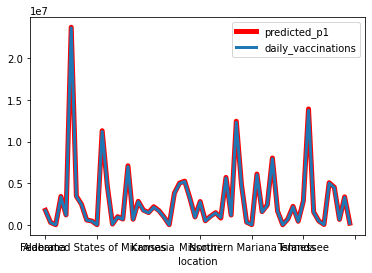

In [244]:
data_panel_test_us = data_panel_test.groupby('location').sum()
ax1 = data_panel_test_us.plot(y = 'predicted_p1', color = 'red', linewidth = 5)
data_panel_test_us.plot(y = 'daily_vaccinations', ax = ax1, linewidth = 3)
plt.show()

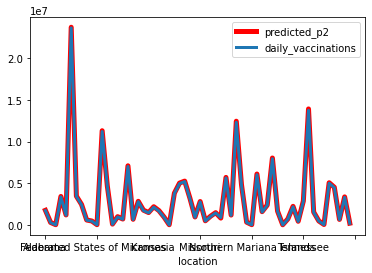

In [245]:
ax2 = data_panel_test_us.plot(y = 'predicted_p2', color = 'red', linewidth = 5)
data_panel_test_us.plot(y = 'daily_vaccinations', ax = ax2, linewidth = 3)
plt.show()

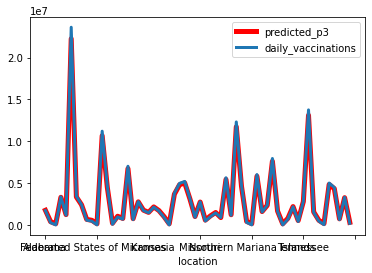

In [246]:
ax3 = data_panel_test_us.plot(y = 'predicted_p3', color = 'red', linewidth = 5)
data_panel_test_us.plot(y = 'daily_vaccinations', ax = ax3, linewidth = 3)
plt.show()

### Stock Price

In [295]:
case_confirmed

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6760,6763,6763,6773,6793,6819,6835,6876,6879,6882,6889,6890,6897,6904,6907,6909,6910,6910,6914,6914,6918,6918,6920,6920,6926,6928,6938,6971,7001,7005,7010,7015,7017,7049,7106,7113,7118,7118,7126,7135
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20714,20723,20730,20764,20787,20815,20833,20838,20847,20863,20875,20897,20921,20941,20966,20983,20993,20993,21035,21093,21107,21123,21131,21135,21154,21170,21191,21290,21392,21411,21422,21444,21467,21489,21511,21535,21546,21554,21578,21593
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2271,2271,2271,2275,2284,2289,2292,2296,2296,2296,2297,2298,2299,2300,2302,2302,2302,2302,2307,2307,2307,2307,2308,2308,2310,2314,2317,2319,2320,2320,2320,2322,2324,2326,2327,2328,2328,2328,2331,2331
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2563,2563,2567,2569,2569,2573,2578,2582,2584,2584,2588,2591,2593,2594,2596,2596,2597,2597,2604,2604,2604,2605,2607,2607,2609,2612,2615,2630,2645,2647,2648,2651,2652,2656,2657,2656,2658,2659,2660,2662
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6529,6532,6532,6548,6556,6563,6570,6570,6571,6574,6581,6595,6607,6613,6616,6619,6621,6621,6635,6645,6651,6656,6660,6661,6678,6680,6694,6750,6771,6773,6776,6794,6808,6816,6826,6829,6832,6832,6847,6856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3694,3694,3703,3707,3711,3715,3719,3719,3719,3724,3725,3729,3730,3732,3732,3732,3739,3741,3744,3753,3751,3751,3751,3755,3758,3760,3762,3765,3765,3765,3769,3772,3770,3775,3776,3776,3776,3780,3780,3781
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2155,2155,2150,2155,2154,2157,2158,2158,2158,2165,2173,2180,2181,2183,2183,2183,2195,2204,2209,2211,2217,2217,2217,2229,2232,2234,2237,2239,2239,2239,2244,2249,2250,2251,2246,2246,2246,2252,2261,2263
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,898,898,898,898,898,898,898,898,898,898,901,903,903,903,903,903,906,906,911,911,911,911,911,912,913,914,918,918,918,918,917,917,920,92

In [290]:
case_confirmed_state = case_confirmed.groupby('Province_State').sum()
case_confirmed_state = case_confirmed_state.iloc[:,5:]
case_confirmed_state = case_confirmed_state.transpose()
case_confirmed_state['cases_confirm'] = case_confirmed_state.sum(axis = 1)
case_confirmed_us = pd.DataFrame(case_confirmed_state['cases_confirm'])

In [291]:
case_confirmed_us

,cases_confirm
1/22/20,1
1/23/20,1
1/24/20,2
1/25/20,2
1/26/20,5
...,...
5/22/21,33104884
5/23/21,33117737
5/24/21,33143662
5/25/21,33166418


In [299]:
case_death_state = case_death.groupby('Province_State').sum()
case_death_state = case_death_state.iloc[:,6:]
case_death_state = case_death_state.transpose()
case_death_state['cases_death'] = case_death_state.sum(axis = 1)
case_death_us = pd.DataFrame(case_death_state['cases_death'])

In [300]:
case_death_us

,cases_death
1/22/20,1
1/23/20,1
1/24/20,1
1/25/20,1
1/26/20,1
...,...
5/22/21,589703
5/23/21,589893
5/24/21,590320
5/25/21,590941
